In [14]:
import tf_keras as keras
import tensorflow as tf
import tensorflow_model_optimization as tfmot

from preprocessing import dataset_preprocessing, tensorflow_to_numpy_dataset
from evaluation import evaluate_lite_model
from utils import get_zipped_model_size

print('TensorFlow version: ', tf.__version__)

TensorFlow version:  2.16.1


In [15]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
EPOCHS = 70
DROPOUT = 0.2
SCALE = 127.5
OFFSET = -1

PATH = "..\dataset_04"

LOADED_MODEL = "04_pruned_mobilenet_v2_0.35_224"
MODEL_NAME = "04_quantized_mobilenet_v2_0.35_224"

In [16]:
dataset = keras.utils.image_dataset_from_directory(PATH,
                                                   shuffle = True,
                                                   batch_size = BATCH_SIZE,
                                                   image_size = (IMAGE_SIZE, IMAGE_SIZE))

class_names = dataset.class_names
number_classes = len(class_names)

training_dataset, validation_dataset, testing_dataset = dataset_preprocessing(dataset,
                                                                              train_size=0.80,
                                                                              validation_size=0.1, 
                                                                              augmentation_flag = True, 
                                                                              rescaling_flag = True, 
                                                                              prefetch_flag = True, 
                                                                              scale = SCALE, 
                                                                              offset = OFFSET)

Found 1281 files belonging to 9 classes.


In [17]:
model = keras.models.load_model('saved_models/' + LOADED_MODEL + '.keras')

model.compile(optimizer = keras.optimizers.Adam(1e-3),
              loss= keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

_, baseline_accuracy = model.evaluate(testing_dataset, verbose = 0)
print('Baseline accuracy: ', round(baseline_accuracy*100, 3), '%')

Baseline accuracy:  96.25 %


In [18]:
images_batch_np, labels_batch_np = tensorflow_to_numpy_dataset(testing_dataset)

def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(images_batch_np).batch(1).take(100):
    yield [input_value]


converter = tf.lite.TFLiteConverter.from_keras_model(model);
converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

model_integer_quantization = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\ALESSA~1\AppData\Local\Temp\tmp7dodfds9\assets


INFO:tensorflow:Assets written to: C:\Users\ALESSA~1\AppData\Local\Temp\tmp7dodfds9\assets
C:\Users\ALESSANDRO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tensorflow\lite\python\convert.py:964: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [19]:
with open('saved_lite_models/' + MODEL_NAME + '.tflite', "wb") as f:
    f.write(model_integer_quantization)    

In [20]:
print("Original model size: ", get_zipped_model_size('saved_models/' + LOADED_MODEL + '.keras')/10**6, ' MB')
print("Quantized model size: ", get_zipped_model_size('saved_lite_models/' + MODEL_NAME + '.tflite')/10**3, ' kB')

Original model size:  1.005517  MB
Quantized model size:  343.775  kB


Processing test dataset. Batch to process:  5 

Accuracy of compressed model model: 96.25 %


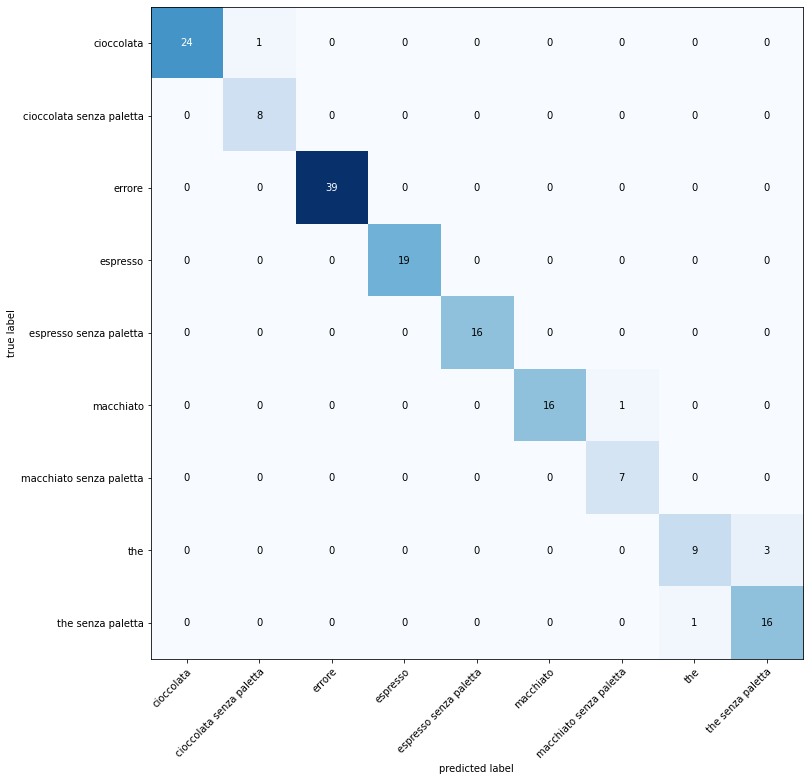

In [21]:
interpreter = tf.lite.Interpreter(model_path='saved_lite_models/' + MODEL_NAME + '.tflite')
interpreter.allocate_tensors()

accuracy = evaluate_lite_model(interpreter, testing_dataset, class_names=class_names, show_confusion_matrix=True)
print("Accuracy of compressed model model: %.2f" %(accuracy*100) , '%')